### Volume Fraction Profiles from SF-SCF Calculations

We employ a two-gradient Scheutjens-Fleer Self-Consistent Field (SF-SCF) method in cylindrical geometry.  
A full description is provided in Supplementary Note 3 of the original work.  
Here we present technical details for the purposes of reproducibility.  

We do not discuss the generation of input files, as this is extensively covered in the Namics/SFbox manual.  
However, we provide an example below.  

Each grafted chain is anchored by a monomer segment pinned to the pore surface.  
Pinned monomers are constrained to the inner cylindrical surface (constant radius).  
This allows them to slide freely along the **z-axis** (one less degree of freedom than a free segment).  
To prevent such lateral motion, the pore is divided along its **z-axis** into discrete slices (rings).  
Each slice defines its own grafting site, thereby immobilizing pinned segments within that slice.  
For each slice, a fraction of chains is grafted to the wall, so that the total polymer quantity is distributed evenly along the pore length and the grafting density is conserved.  

Example input snippet from `SCF/empty_pore_input.in`:

```text
mol:pol0:composition:(P0)1(P)299
mol:pol0:freedom:restricted
mol:pol0:theta:980.1769079200155
mon:P0:freedom:pinned
mon:P0:pinned_range:26,121;26,121
...
mol:pol51:composition:(P0)1(P)299
mol:pol51:freedom:restricted
mol:pol51:theta:980.1769079200155
mon:P51:freedom:pinned
mon:P51:pinned_range:26,172;26,172
```

The numerical SF-SCF algorithm then minimizes the excess Helmholtz free energy subject to the incompressibility constraint, yielding the **equilibrium volume fraction distribution** of polymer segments originating from each grafting slice.  
- In our system, the pore has a length of 52 lattice units, with slices labeled from $z = -26$ to z = $+25$.  
- Each slice corresponds to one set of grafted chains, allowing us to examine how different grafting positions contribute to the overall polymer distribution.  
- The results are stored in the Namics/SFbox output files, which provide the local volume fractions $\phi(r,z)$ for every grafting site.  


The code below loads these results, and plots the **polymer volume fraction profiles**  with an interactive slider.  
An interactive **slider** lets you scroll through the slices along the $z$-axis, visualizing how chains grafted at different axial positions distribute inside the pore.

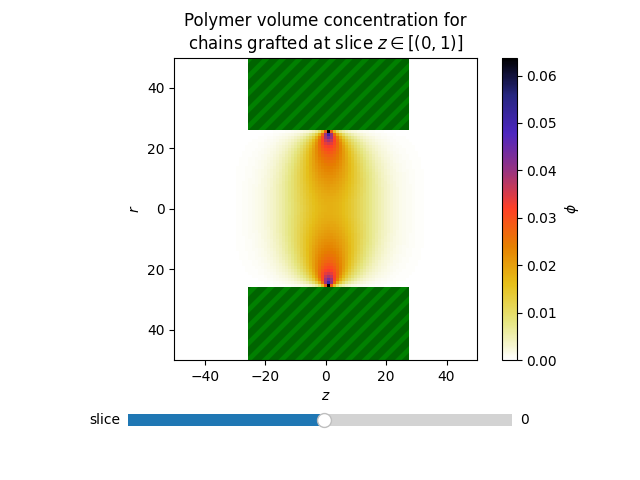

In [29]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from src.read_namics_output import extract_volume_fractions_per_grafting_range, create_walls, build_scf_empty_pore_results
from src.utils import mirror_extend
from src.make_plot import plot_with_slider, plot_grid
from IPython.display import display, clear_output

# raw = pd.read_table("SCF/output/colloid_traversing_pore_62.pro", index_col=False)
SCF_empty_pore_result = build_scf_empty_pore_results("SCF/output/empty_pore_input", chi_PS=0.6)
R = SCF_empty_pore_result["R"]
Z = SCF_empty_pore_result["Z"]
phi_s = SCF_empty_pore_result["phi_s"]
phi_0 = SCF_empty_pore_result["phi"]
if "colloid_mask" in SCF_empty_pore_result:
    colloid_mask = SCF_empty_pore_result["colloid_mask"]
else:
    colloid_mask = np.zeros_like(phi_s[0])
pore_radius = 26
pore_length = 52
walls = create_walls(len(R), len(Z), pore_radius, pore_length).T
fig, ax = plot_with_slider(
    Z, 
    R, 
    #for readability of the plot and consistent formatting with the original work we plot the mirrored array along z axis
    phi_s, 
    fix_clim=True, 
    walls = walls + colloid_mask,
    rlim = (-50,50),
    zlim = (-50,50)
)

### Calculating the Total Polymer Volume Fraction

The premise of our method is to use the polymer volume fraction of a brush **unperturbed by colloid particles**.  
To obtain this, we must sum the volume fractions of all polymer chains grafted along the pore.  

This can be done in two equivalent ways:

1. **Per slice:** summing the volume fraction of all chains grafted at each slice along the $z$-axis.  
2. **Per monomer type:** summing the volume fraction contributions of every chain segment type in the polymer brush.  

Both datasets are available in the Namics/SFbox output files.  
Here, we use the **per-slice method**.

The calculation is expressed as:

$$
\phi_n(r,z) = \sum_{s=1}^{N} \phi_s(r,z)
$$

where  
- $s$ is the index of a chain segment ($s = 1, \dots, N$),  
- $\phi_s(r,z)$ is the volume fraction of segment $s$,  
- $\phi_n(r,z)$ is the total volume fraction of a chain grafted at slice $n$.  

Finally, summing over all grafting slices yields the overall polymer volume fraction:

$$
\phi(r,z) = \sum_{n=0}^{L} \phi_n(r,z)
$$

where $n$ is the slice index along the pore length $L$.


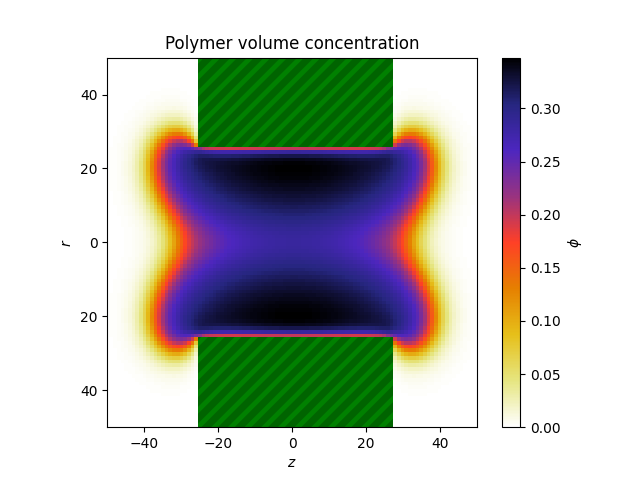

In [4]:
fig, ax = plot_grid(
    Z, 
    R, 
    phi_0, 
    walls = walls + colloid_mask,
    rlim = (-50,50),
    zlim = (-50,50)
)

### Modeling Colloid Insertion and Traversal

Minor modifications to the input files allow us to model the insertion of a **cylindrical colloid particle** into the pore, and ultimately its traversal along the central axis.  
The key changes are introduced in `SCF/colloid_traversing_pore.in`.

```text
mon:P:chi_C:0.0
mon:C:freedom:frozen
mon:C:frozen_range:1,18;3,23
...
start
mon:C:frozen_range:1,64;3,69
start
mon:C:frozen_range:1,65;3,70
start
mon:C:frozen_range:1,66;3,71
...
```

Here, the frozen range specifies lattice cells that are impermeable to the polymer, effectively modeling the colloid particle.
Sequential calculations with a rolling frozen range correspond to the particle moving stepwise along the pore axis.

In this example, we model an inert colloid, characterized by a polymer-colloid interaction parameter $\chi_\text{PC} = 0$




In [31]:
from src.read_namics_output import build_scf_results

#We use this in our example calculations
input_parameters_for_SCF = {
    "colloid_diameter":6,
    "colloid_positions" : [-126]+list(range(-80, 1, 1)),
    "chi_PS":0.6,
    "chi_PC":0.0,
}

#Result are collected to the table
SCF_results = build_scf_results("SCF/output/colloid_traversing_pore", **input_parameters_for_SCF, verbose=True)
clear_output()
display(SCF_results)

,colloid_position,free_energy,R,Z,colloid_mask,phi,chi_PS,chi_PC,colloid_diameter
0,-126,0.000000e+00,"[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, ...","[-145.0, -144.0, -143.0, -142.0, -141.0, -140....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.807248975536214e-36, 4.810278853221177e-36...",0.6,0.0,6
1,-80,4.254362e-07,"[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, ...","[-145.0, -144.0, -143.0, -142.0, -141.0, -140....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[2.3824091847953278e-36, 6.499113029499542e-3...",0.6,0.0,6
2,-79,-1.070552e-06,"[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, ...","[-145.0, -144.0, -143.0, -142.0, -141.0, -140....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[2.3844317397246058e-36, 6.504955308354355e-3...",0.6,0.0,6
3,-78,-1.216409e-06,"[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, ...","[-145.0, -144.0, -143.0, -142.0, -141.0, -140....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[2.386297029449025e-36, 6.510346675233576e-36...",0.6,0.0,6
4,-77,-6.565788e-07,"[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, ...","[-145.0, -144.0, -143.0, -142.0, -141.0, -140....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[2.3880129751339455e-36, 6.515309720142424e-3...",0.6,0.0,6
...,...,...,...,...,...,...,...,...,...
60,-21,2.996228e+00,"[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, ...","[-145.0, -144.0, -143.0, -142.0, -141.0, -140....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[2.43821211640761e-36, 6.655102363130437e-36,...",0.6,0.0,6
61,-20,3.094260e+00,"[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, ...","[-145.0, -144.0, -143.0, -142.0, -141.0, -140....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[2.436285751177017e-36, 6.649836884016277e-36...",0.6,0.0,6
62,-19,3.185288e+00,"[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, ...","[-145.0, -144.0, -143.0, -142.0, -141.0, -140....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[2.434701025773757e-36, 6.645504752834662e-36...",0.6,0.0,6
63,-18,3.270075e+00,"[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, ...","[-145.0, -144.0, -143.0, -142.0, -141.0, -140....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[2.4333500144890683e-36, 6.641811237280256e-3...",0.6,0.0,6


## Colloid particle disturbs local polymer density

As whe chose $\chi_{\text{PC}} = 0$ which corresponds to inert colloid, one can see depleted region forming around the particle
The figure below provides intercative view, use slider to control colloid position.
Note the insertion free energy in the lower right box, it is always positive

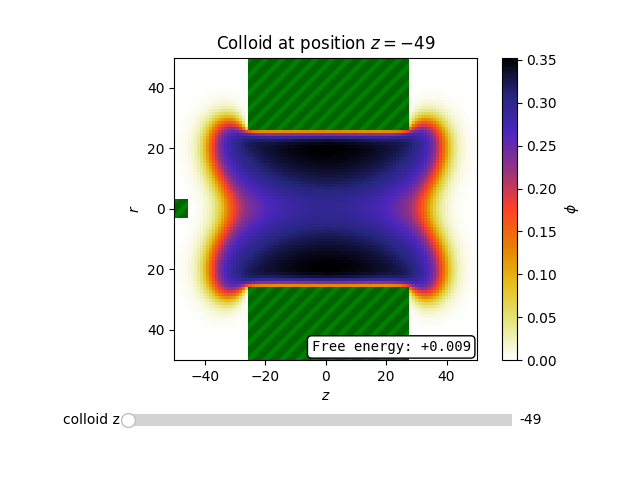

In [32]:

from src.make_plot import plot_phi_with_colloid_slider
fig = plot_phi_with_colloid_slider(
    SCF_results.iloc[30:], 
    fix_clim=True,
    walls=walls,     
    rlim = (-50,50),
    zlim = (-50,50)
    )

# Fitting b0 and b1 to match analytical model to SF-SCF data
The optimal coefficient is found using least squares method, i.e minimizing

$$
\sum_{\text{Parameters}} |\Delta F_{\text{SF-SCF}} - \Delta F_{cyl}|^2
$$
Where $\text{Parameters}$ are varying: $\chi_{\text{PS}}$, $\chi_{\text{PC}}$, $z_c$.
Here we present fit performed only for  $\chi_{\text{PS}} = 0.6$ (less data then in the original study) and $d=4$ (the same as in original study)

We will use already precomputed insertion free energy values

In [33]:
import pandas as pd
#to spare time we present a selection of precomputed values for small particles used to preform fit for chi_PS = 0.6, chi_PC = 0.0, -0.5, -1.0, -1.5
precomputed_SCF_results = pd.read_pickle("/home/ml/Studium/sfb_empty_pore/precomputed_SCF_results.pkl")
display(precomputed_SCF_results)


,chi_PS,chi_PC,colloid_position,colloid_diameter,free_energy,phi,colloid_mask,R,Z
804,0.6,-1.5,-126,4,0.000,"[[1.07491e-36, 3.0282882e-36, 1.0375028e-35, 3...","[[False, False, False, False, False, False, Fa...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-146, -145, -144, -143, -142, -141, -140, -13..."
3417,0.6,-0.5,-126,6,0.000,"[[7.4496472e-37, 2.0295959e-36, 6.7197966e-36,...","[[False, False, False, False, False, False, Fa...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-146, -145, -144, -143, -142, -141, -140, -13..."
848,0.6,-1.5,-126,6,0.000,"[[1.4553931e-36, 4.1172563e-36, 1.414067e-35, ...","[[False, False, False, False, False, False, Fa...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-146, -145, -144, -143, -142, -141, -140, -13..."
4472,0.6,0.0,-126,4,0.000,"[[7.5001447e-37, 2.0547429e-36, 6.8458414e-36,...","[[False, False, False, False, False, False, Fa...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-146, -145, -144, -143, -142, -141, -140, -13..."
3343,0.6,-0.5,-126,4,0.000,"[[8.1020897e-37, 2.2338636e-36, 7.4908694e-36,...","[[False, False, False, False, False, False, Fa...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-146, -145, -144, -143, -142, -141, -140, -13..."
...,...,...,...,...,...,...,...,...,...
2087,0.6,-1.0,21,4,-1.114,"[[8.4497727e-37, 2.3433421e-36, 7.9071897e-36,...","[[False, False, False, False, False, False, Fa...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-146, -145, -144, -143, -142, -141, -140, -13..."
2065,0.6,-1.0,22,4,-1.111,"[[8.4495171e-37, 2.3432711e-36, 7.9069499e-36,...","[[False, False, False, False, False, False, Fa...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-146, -145, -144, -143, -142, -141, -140, -13..."
2062,0.6,-1.0,23,4,-1.106,"[[8.4492181e-37, 2.3431881e-36, 7.9066695e-36,...","[[False, False, False, False, False, False, Fa...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-146, -145, -144, -143, -142, -141, -140, -13..."
2046,0.6,-1.0,24,4,-1.099,"[[8.4488607e-37, 2.3430889e-36, 7.9063343e-36,...","[[False, False, False, False, False, False, Fa...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-146, -145, -144, -143, -142, -141, -140, -13..."


## Explore insertion free energy and local perturbation to polymer density

Select the parameter values in the dropdown list and control colloid position by moving slider. Note the insertion free energy values and magnitude. We advice you to follow data in the Figure S6 of the original work

The data has been calculated with high fidelity with respect to particle position for smaller particles, as they were used in the fit. Larger particles were examined to set validity range, and thus has been modeled sparsely.

In [34]:
#explore 
from src.make_plot import interactive_plot_phi
interactive_plot_phi(
    precomputed_SCF_results,
    fix_clim=True,
    walls=walls,     
    rlim = (-50,50),
    zlim = (-50,50),)


SELECT PARAMETERS:


## Surface and volume projection matrices for cylindrical particles

Following Supplementary Note 4, to build analytical calculation of $\Delta F_{\text{cyl}}$ we require surface and volume matrices.

While colloid of size 4 in diameter was used for the fit, we encourage you to plot matrices to larger particles to, as it was used to compute $\Delta F_{\text{cyl}}$ with fitted model for larger particles

Cylindrical particle volume projection matrix:
[[3.14159265 3.14159265 3.14159265 3.14159265]
 [9.42477796 9.42477796 9.42477796 9.42477796]]

Cylindrical particle surface projection matrix:
[[ 3.14159265  0.          0.          3.14159265]
 [21.99114858 12.56637061 12.56637061 21.99114858]]


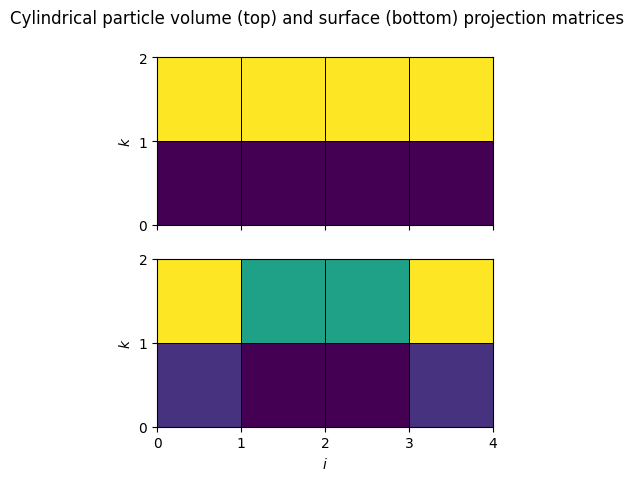

In [1]:
import numpy as np
from src.make_plot import plot_volume_and_surface_matrices_cylinder
def cylinder_r0_kernel(radius:int, height:int = None):
    if height is None:
        height = radius*2
    r = np.arange(radius)
    volume_r = np.pi*(2*r+1)
    volume = np.tile(volume_r, (height,1)).T
    surface = np.zeros_like(volume)

    surface[:, 0] = surface[:,-1] = volume_r
    surface[-1,:] =surface[-1,:] + 2*np.pi*radius
    return volume, surface

COLLOID_DIAMETER = 4

volume, surface = cylinder_r0_kernel(COLLOID_DIAMETER//2, COLLOID_DIAMETER)
plot_volume_and_surface_matrices_cylinder(volume, surface)




In [22]:
def gamma_model(chi_PS, chi_PC, phi, X):
    #Number of fitting parameters X can be expanded, but just two is already produce adequate results
    b0, b1 = X
    chi_crit = 6*np.log(5/6)
    phi_corrected = (b0 + b1*chi_PC)*phi
    chi_ads = chi_PC - chi_PS*(1-phi_corrected)
    gamma = (chi_ads - chi_crit)*phi_corrected/6
    return gamma

def Pi(phi, chi_PS):
    Pi_=-np.log(1-phi) - phi - chi_PS*phi**2
    return Pi_

def insertion_free_energy_cylinder(radius, phi_0, chi_PS, chi_PC, gamma_method, X_args):
    from scipy.signal import convolve
    volume, surface = cylinder_r0_kernel(radius)
    phi_0 = np.pad(phi_0[0:radius], ((0, 0),(radius,radius-1)))
    Pi_arr = Pi(phi_0, chi_PS)
    gamma_arr = gamma_method(chi_PS, chi_PC, phi_0, X_args)
    osmotic = convolve(Pi_arr, volume, 'valid')[0]
    surface = convolve(gamma_arr, surface, 'valid')[0]
    return osmotic+surface

def create_cost_function(SCF_results, SCF_results_empty, gamma_model):
    def cost_function(X):
        cost = np.array([])
        for (chi_PS, chi_PC, colloid_diameter), group in SCF_results.groupby(by = ["chi_PS", "chi_PC", "colloid_diameter"]):
            # we have data calculated for chi_PS = 0.6, so everything is okay otherwise
            # if we want to generalize it for other chi_PS, it has to be calculated
            empty_pore_data = SCF_results_empty.loc[SCF_results_empty.chi_PS == chi_PS, "phi"].squeeze()
            FE = insertion_free_energy_cylinder(
                colloid_diameter//2, empty_pore_data, 
                chi_PS, chi_PC, gamma_model, X,
                )
            residuals = group.apply(lambda _: _.free_energy - FE[int(_.colloid_position+len(FE)//2)], axis = 1)
            # delta_fe = np.cbrt(delta_fe)
            cost = np.concatenate([cost, residuals.to_numpy()])
        return cost
    return cost_function

X0 = [1,0]
from scipy.optimize import least_squares
cost_function = create_cost_function(
    precomputed_SCF_results, 
    pd.DataFrame([SCF_empty_pore_result]), #here we provide dataframe with all SCF results of empty pores, to map chi_PS to phi in the empty pore
    gamma_model=gamma_model
    )
b0, b1 = map(float, least_squares(cost_function, X0).x)


print(f"{b0=}, {b1=}")

b0=0.6993128436449816, b1=-0.32881190826589896
